In [1]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
EXAMPLE_NAME = os.path.basename(EXAMPLE_DIR)
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

EXAMPLE_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing
PROJECT_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox


In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video, display

import sys
import time
import numpy as np
from typing import List
from pathlib import Path
from collections import defaultdict

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis import MultiObjectiveSolver
from src.simulation.simulator import Simulator
from src.graph.trans_sys import FiniteTransSys


from wombats.systems.minigrid import GYM_MONITOR_LOG_DIR_NAME
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, MultiAgentMiniGridEnv

DIR = EXAMPLE_DIR
Graph.graph_dir = DIR

In [3]:
debug = True

dfa_config_yaml="config/DFA"
pdfa_config_yaml="config/PDFA"

# Graph Arguments
load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

# Multi-Objective Optimizer Arguments
stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

# Construct DFA and Manually Specify PDFA from DFA 



In [17]:
dfa = graph_factory.get(
    'DFA',
    graph_name=f"{EXAMPLE_NAME}_DFA",
    sc_ltl="o1 & X(o2 & X(o3) || o3 & X(o2))" + "|| o2 & X(o1 & X(o3) || o3 & X(o1)) " + "|| o3 & X(o2 & X(o1) || o1 & X(o2))",
    config_yaml=dfa_config_yaml,
    save_flag=save_flag,
    plot=False,
    view=view,
    format=format)

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing/plots/franka_box_packing_DFA.png


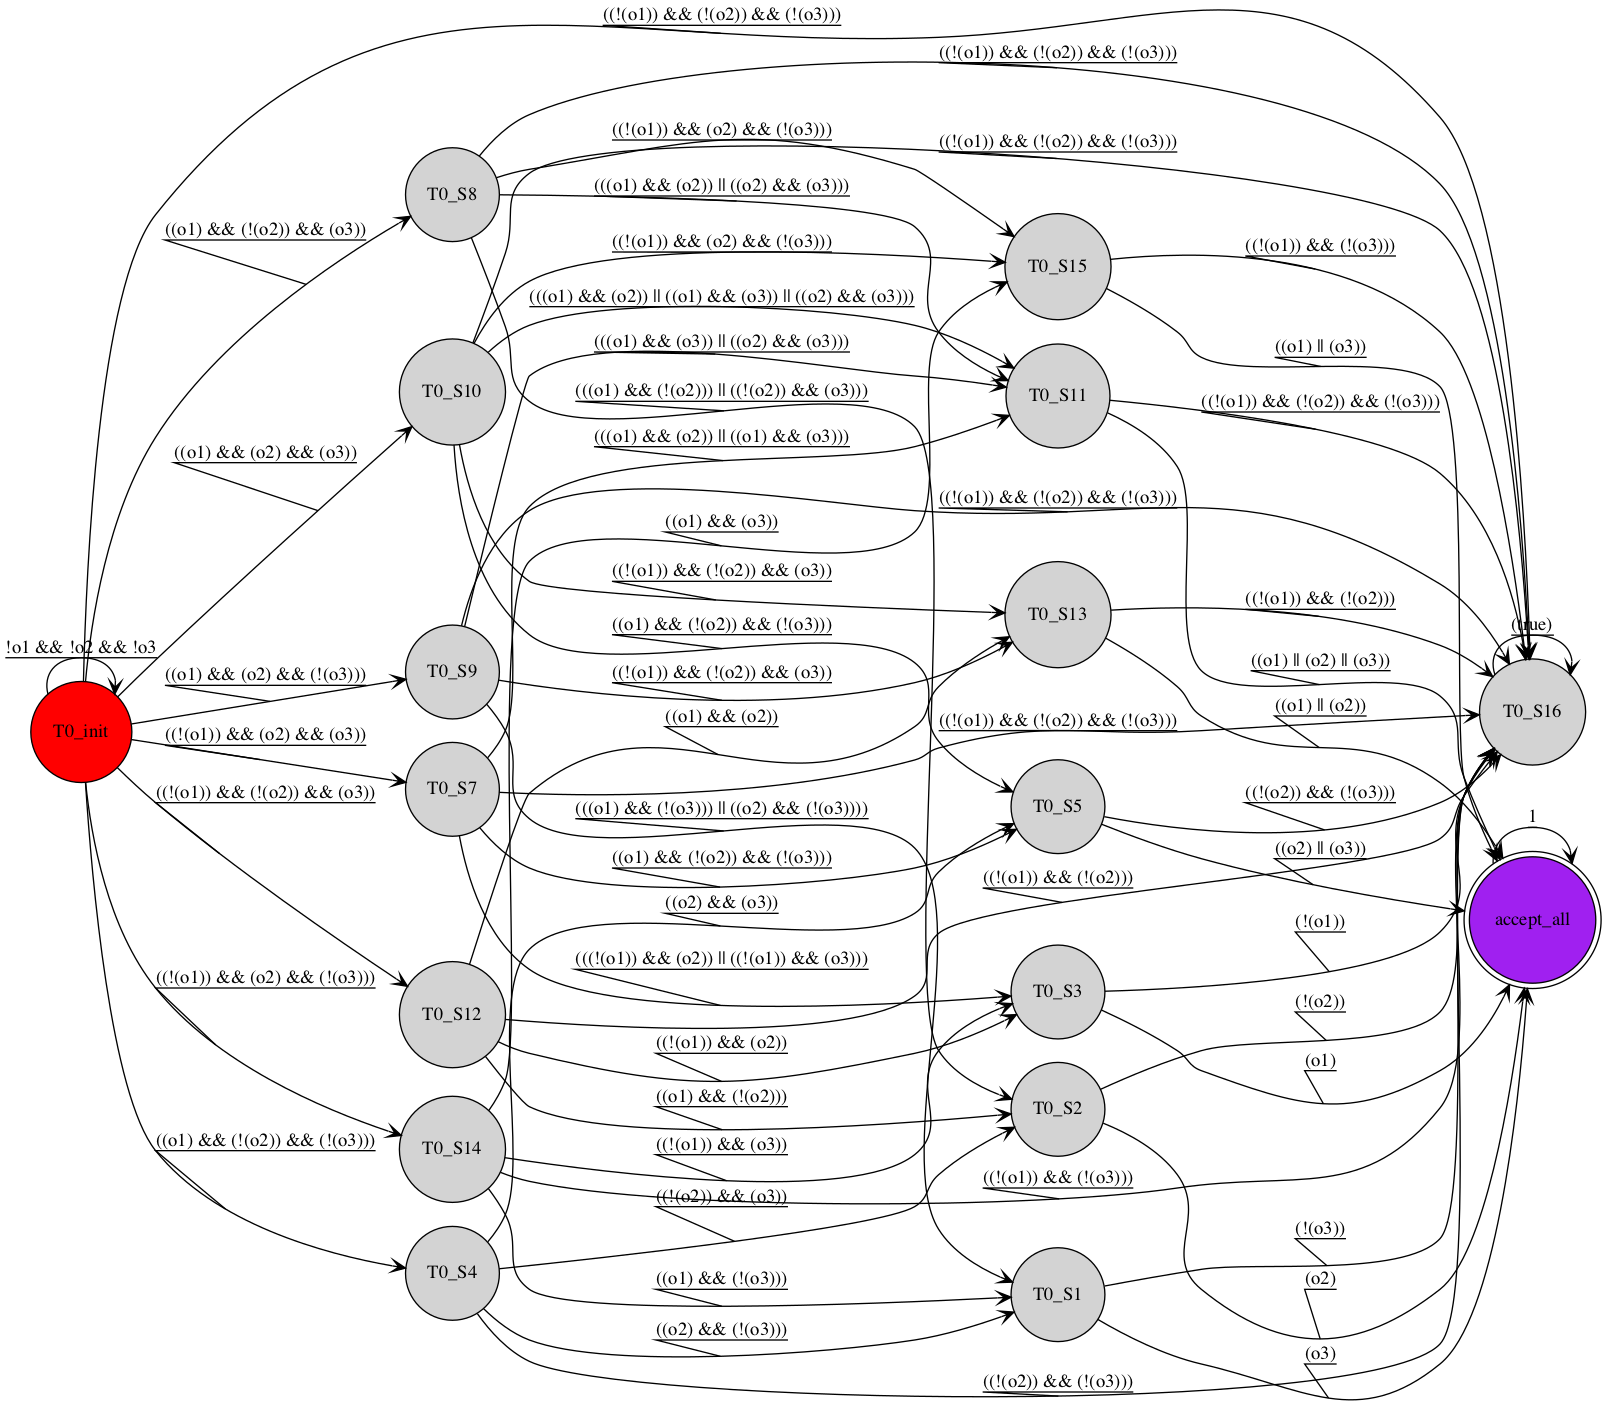

In [18]:

from src.spot.Parser import parse as parse_guard

# TODO: THIS IS HACKY. We add an extra self-loop at the initial state!


transition_formula = '!o1 && !o2 && !o3'
transition_expr = parse_guard(transition_formula)
dfa.add_edge('T0_init', 'T0_init',
             guard=transition_expr,
             guard_formula=transition_formula)
dfa.plot_graph(view=view, format=format)

# Manually Define Game
Given a list of objects, construct a product graph


In [35]:
import queue
import networkx as nx

# 1. Define a transition (two player game) graph for ONE object
#       The function "construct_object_graph" constructs a graph for ONE object

# 2 .Take the product between multiple objects
#       The function "construct_graph" constructs a graph for multiple objects of same type


def construct_object_graph(object_num: int=1, graph_name: str=None, weight: float=1):
    
    if graph_name is None:
        graph_name = f'o{object_num}'

    trans_sys = FiniteTransSys(graph_name, config_yaml=None, save_flag=False)
    trans_sys._graph = nx.MultiDiGraph(name=graph_name)

    loc = f'L{object_num}'
    box = 'Box'
    trans_sys.add_state(loc, ap='')
    trans_sys.add_state(box, ap=graph_name)
    trans_sys.add_edge(loc, box, actions=f'move_{graph_name}_{loc}_{box}', weight=weight)
    trans_sys.add_initial_state(loc)
    return trans_sys

def construct_graph(
    num_object: int = None, 
    object_names: List[str] = None, 
    save_flag: bool = True, 
    graph_name: str = None,
    weights: List[float] = None):

    if num_object is None and object_names is None:
        raise Exception('Either num_object or object_names must be given')

    if weights is None:
        n = num_object if num_object is not None else len(object_names)
        weights = [1]*n

    if num_object is not None:
        obj_graphs = [construct_object_graph(i+1, weight=weights[i]) for i in range(num_object)]
    else:
        obj_graphs = [construct_object_graph(graph_name=nam, weight=w) for name, w in zip(object_names, weights)]

    init_node = tuple(g.get_initial_states()[0][0] for g in obj_graphs)
    
    searchQueue = queue.Queue()
    visited = defaultdict(lambda: False)

    searchQueue.put(('eve', init_node))
    visited[init_node] = True
    
    if graph_name is None:
        graph_name = ''.join([f'o{i+1}' for i in range(num_object)])
    trans_sys = FiniteTransSys(graph_name, config_yaml=None, save_flag=save_flag)
    trans_sys._graph = nx.MultiDiGraph(name=graph_name)

    aps = [i_g._graph.nodes[n]['ap'] for i_g, n in zip(obj_graphs, init_node)]
    ap = ''.join(aps)
    trans_sys.add_state(str(init_node), ap=ap, player='eve')
    trans_sys.add_initial_state(str(init_node))

    while not searchQueue.empty():

        player, _u_prod_node = searchQueue.get()

        for i in range(num_object):

            s = _u_prod_node[i]
            g = obj_graphs[i]

            for n_s in g._graph.successors(s):
                e_kwargs = g._graph[s][n_s]
                
                _v_prod_node = tuple(n if i!=j else n_s for j, n in enumerate(_u_prod_node))

                aps = [i_g._graph.nodes[n]['ap'] for i_g, n in zip(obj_graphs, _v_prod_node)]
                aps = [string for string in aps if len(string)!=0]
                ap = set(aps)
                # ap = set([g._graph.nodes[n_s]['ap']])

                next_player = 'adam' if player == 'eve' else 'eve'

                if not visited[_v_prod_node]:
                    searchQueue.put((next_player, _v_prod_node))
                    visited[_v_prod_node] = True

                if not trans_sys._graph.has_node(_v_prod_node):
                    trans_sys.add_state(str(_v_prod_node), ap=ap, player=next_player)

                for i, kwargs in e_kwargs.items():
                    trans_sys.add_edge(str(_u_prod_node), str(_v_prod_node), **kwargs)

    return trans_sys


In [36]:
trans_sys = construct_graph(3, graph_name=f'{EXAMPLE_NAME}_GAME')

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing/plots/franka_box_packing_GAME.png


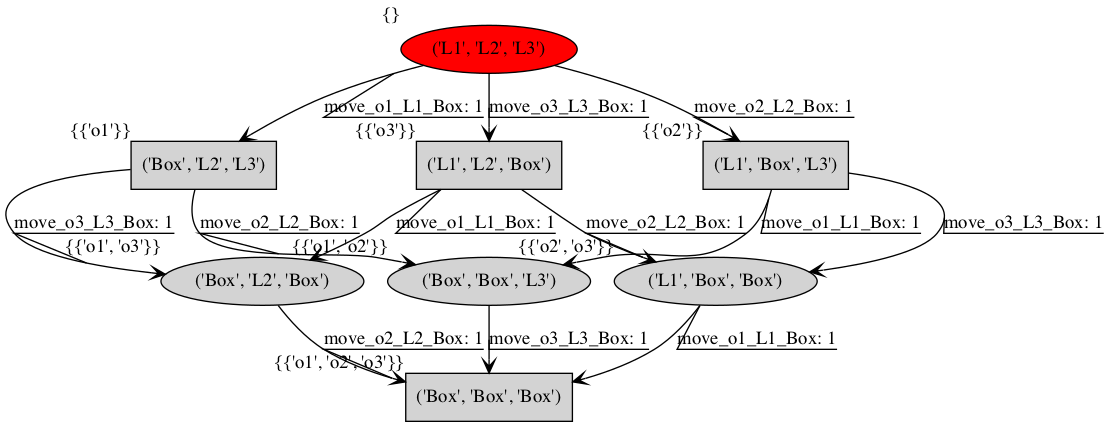

In [37]:
trans_sys.plot_graph(format=format, view=view)

In [38]:
# Product Game Construction
start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name=f'{EXAMPLE_NAME}_ProductAutomaton',
    config_yaml=None,
    trans_sys=trans_sys,
    automaton=dfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

Product Construction took 0.01 seconds


/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/src/graph/base.py:556: UserWarning: WARNING: The set of trap states is empty. Returning an empty list.
  warnings.warn("WARNING: The set of trap states is empty. Returning an empty list.")


/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing/plots/franka_box_packing_ProductAutomaton.png


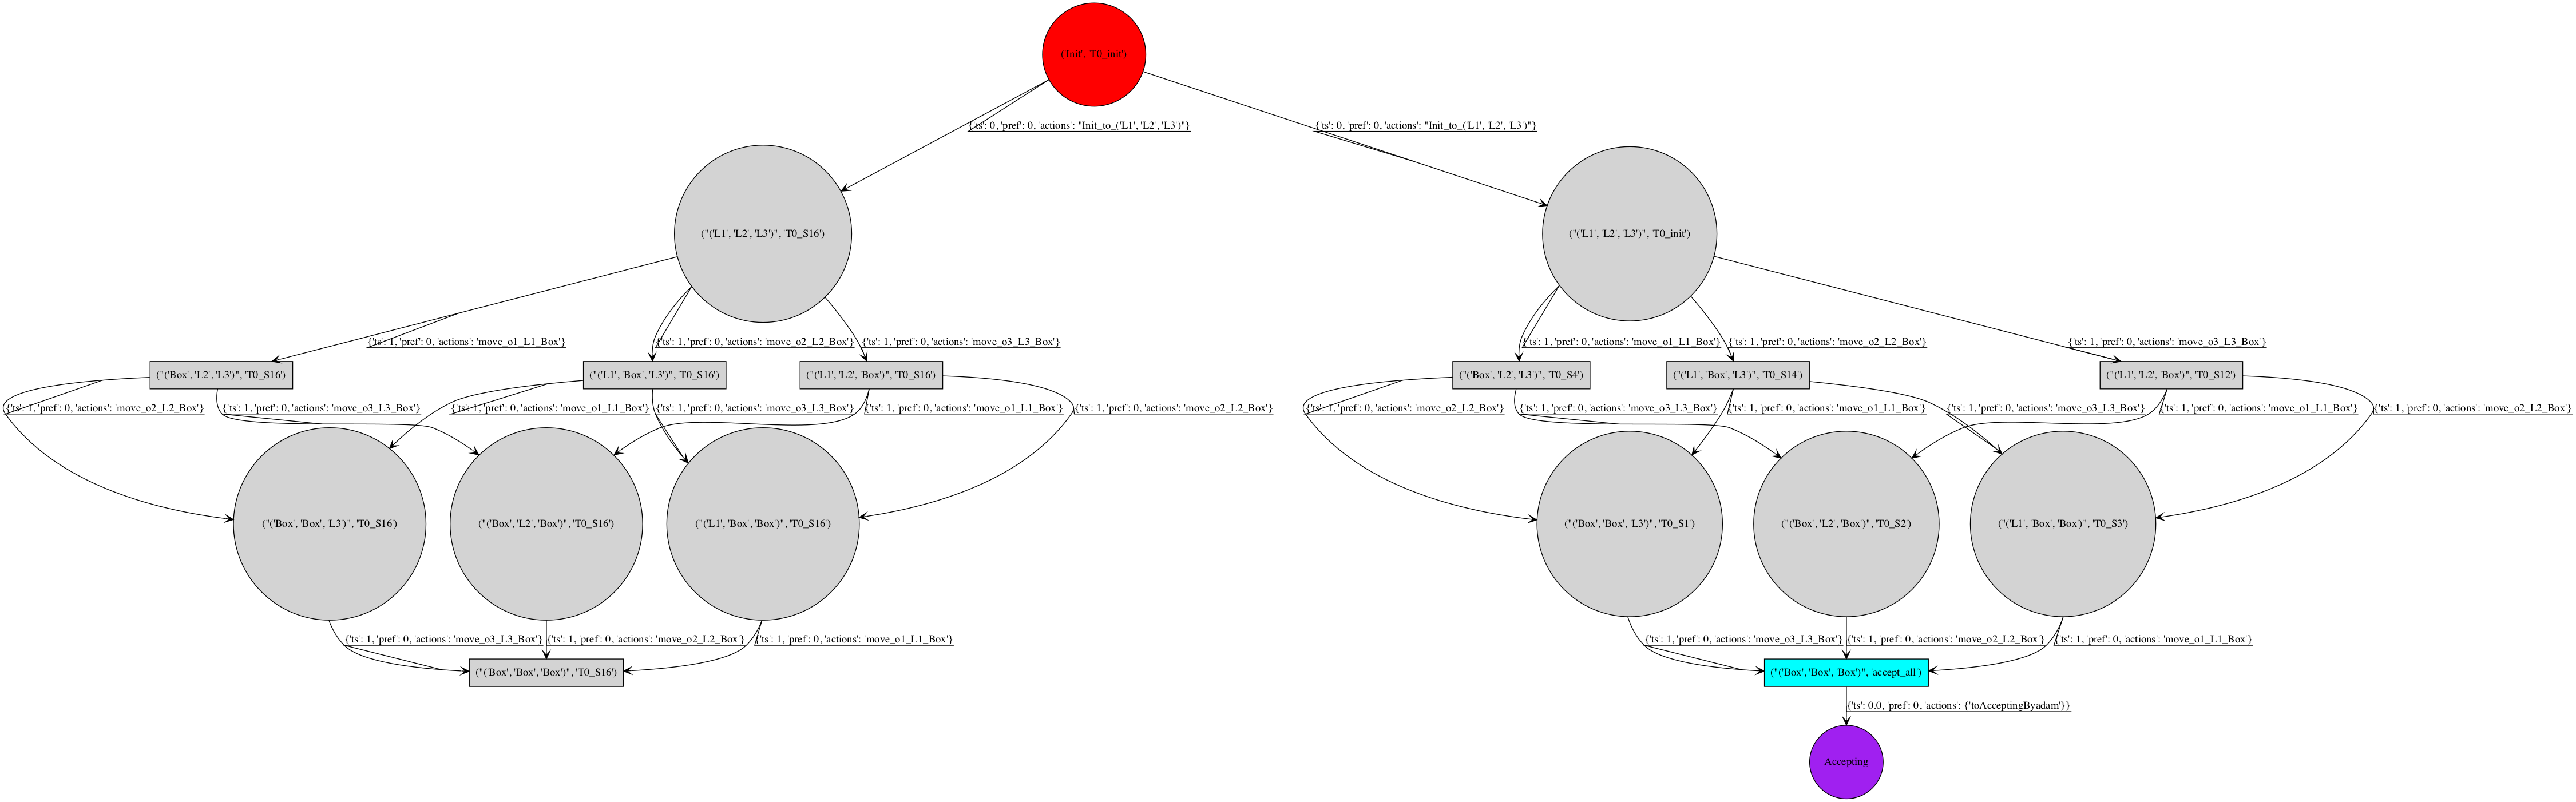

In [39]:
game.plot_graph(view=view, format=format)

18 nodes and 27 edges
1th Iteration took 0.01 seconds
2th Iteration took 0.01 seconds
Pareto Points Computation took 0.02 seconds


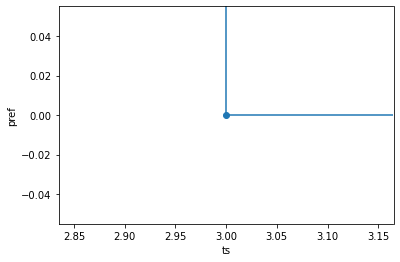

(array([[3., 0.]]),
 {(3.0, 0.0): <src.prism.strategy.DeterministicStrategy at 0x7fa45f6eceb0>})

In [15]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-5,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/config/Strategy.yaml
/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/plots/DeterministicStrategyFor(3.0,0.0).png


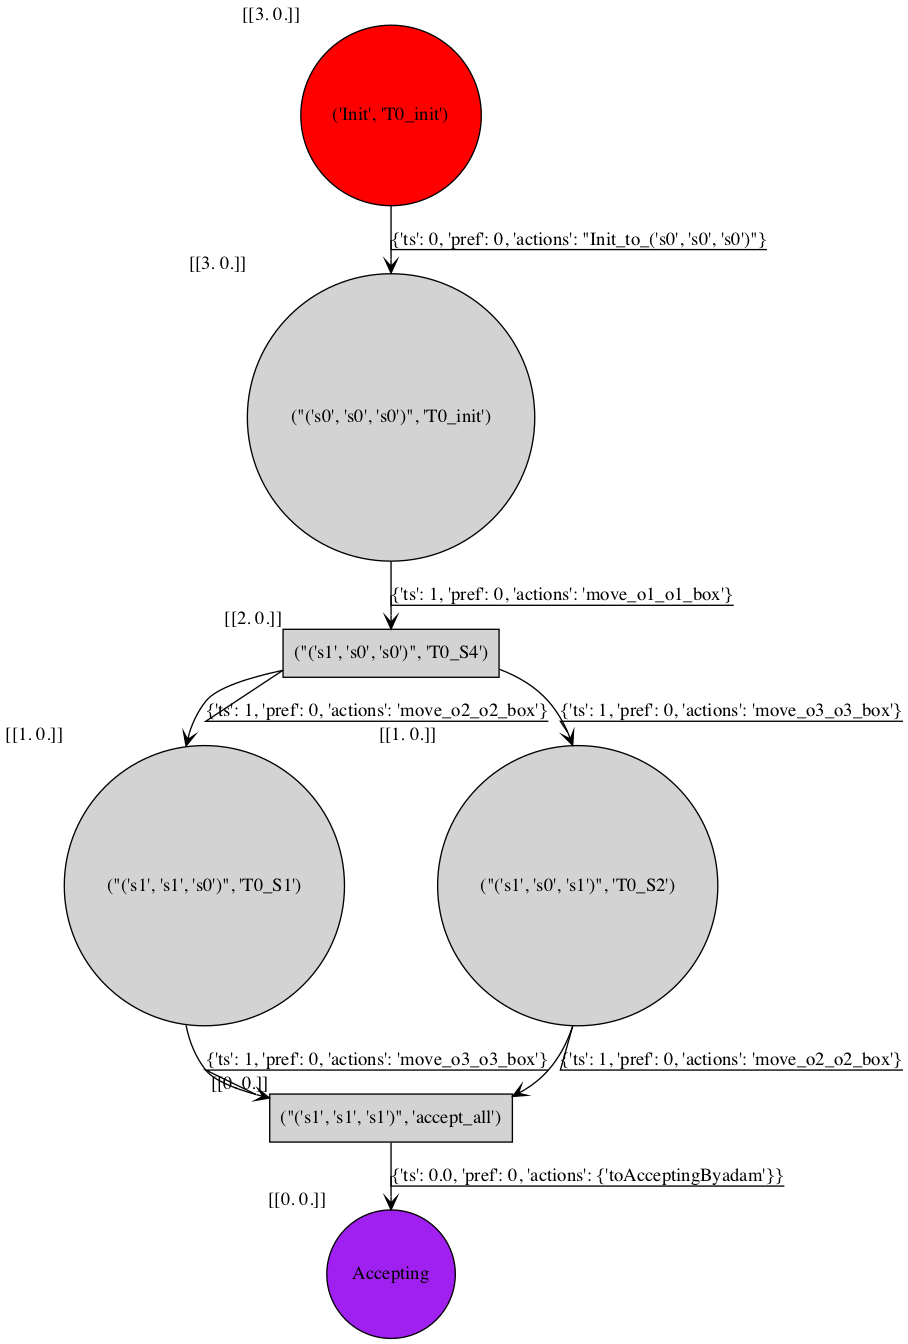

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/config/Strategy.yaml


In [49]:
strategies = solver.get_strategies()
strategy = list(strategies.values())[0]
strategy._config_yaml = "config/Strategy"
strategy.plot_graph(view=view, format=format, save_yaml=True)